In [1]:
# import google drive
from google.colab import drive

# mount google drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# unzip data.zip
!unzip "/content/drive/MyDrive/studies/ai-project/data.zip" -d /content/data_dir


Archive:  /content/drive/MyDrive/studies/ai-project/data.zip
   creating: /content/data_dir/nucleus/
  inflating: /content/data_dir/nucleus/48.png  
  inflating: /content/data_dir/nucleus/47.png  
  inflating: /content/data_dir/nucleus/46.png  
  inflating: /content/data_dir/nucleus/45.png  
  inflating: /content/data_dir/nucleus/44.png  
  inflating: /content/data_dir/nucleus/43.png  
  inflating: /content/data_dir/nucleus/42.png  
  inflating: /content/data_dir/nucleus/41.png  
  inflating: /content/data_dir/nucleus/40.png  
  inflating: /content/data_dir/nucleus/4.png  
  inflating: /content/data_dir/nucleus/39.png  
  inflating: /content/data_dir/nucleus/38.png  
  inflating: /content/data_dir/nucleus/37.png  
  inflating: /content/data_dir/nucleus/36.png  
  inflating: /content/data_dir/nucleus/35.png  
  inflating: /content/data_dir/nucleus/34.png  
  inflating: /content/data_dir/nucleus/33.png  
  inflating: /content/data_dir/nucleus/32.png  
  inflating: /content/data_dir/nucle

In [3]:
# import
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import train_test_split


In [4]:
# data_dir
data_dir = "/content/data_dir"
data_dir = pathlib.Path(data_dir)


In [5]:
# image_count
image_count = len(list(data_dir.glob('*/*.*')))


In [6]:
# configs
batch_size = 3
img_height = 128
img_width = 128


In [8]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  

Found 340 files belonging to 2 classes.
Using 272 files for training.


In [9]:
# validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 340 files belonging to 2 classes.
Using 68 files for validation.


In [10]:
# class names
class_names = train_ds.class_names


In [11]:
# serialize data
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))


In [12]:
# performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
# imagePaths
imagePaths = []

for k, class_name in enumerate(class_names):
    for f in os.listdir(str(data_dir)+"/"+class_name):
        imagePaths.append([str(data_dir)+"/"+class_name+'/'+f, k])

random.shuffle(imagePaths)


In [14]:
# data and labels
data = []
labels = []

for imagePath in imagePaths:
    image = cv2.imread(imagePath[0])
    image = cv2.resize(image, (img_width, img_height))
    data.append(image)
    
    label = imagePath[1]
    labels.append(label)


In [15]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)


In [16]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)


In [17]:
# create model
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

  tf.keras.layers.Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

  tf.keras.layers.Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

  tf.keras.layers.Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

  tf.keras.layers.Conv2D(512, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(512, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

  tf.keras.layers.Conv2D(1024, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(1024, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),

  tf.keras.layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same'),
  tf.keras.layers.Conv2D(512, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(512, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),

  tf.keras.layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same'),
  tf.keras.layers.Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),

  tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same'),
  tf.keras.layers.Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),

  tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same'),
  tf.keras.layers.Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same'),

  tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid'),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(class_names))
])


In [18]:
# compile model
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [20]:
# train model
epochs = 3
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/3
91/91 [==============================] - 286s 3s/step - loss: 1.0459 - accuracy: 0.5037 - val_loss: 0.6902 - val_accuracy: 0.6029
Epoch 2/3
91/91 [==============================] - 280s 3s/step - loss: 0.6933 - accuracy: 0.5184 - val_loss: 0.6893 - val_accuracy: 0.6029
Epoch 3/3
91/91 [==============================] - 280s 3s/step - loss: 0.6932 - accuracy: 0.5184 - val_loss: 0.6886 - val_accuracy: 0.6029


In [21]:
# Evaluate accuracy
test_loss, test_acc = model.evaluate(testX, testY, verbose=2)
print('\nTest accuracy:', test_acc)


3/3 - 16s - loss: 0.6950 - accuracy: 0.4658

Test accuracy: 0.465753436088562


In [23]:
# Make predictions
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(testX)



In [30]:
# helper
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(len(class_names)))
  plt.yticks([])
  thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

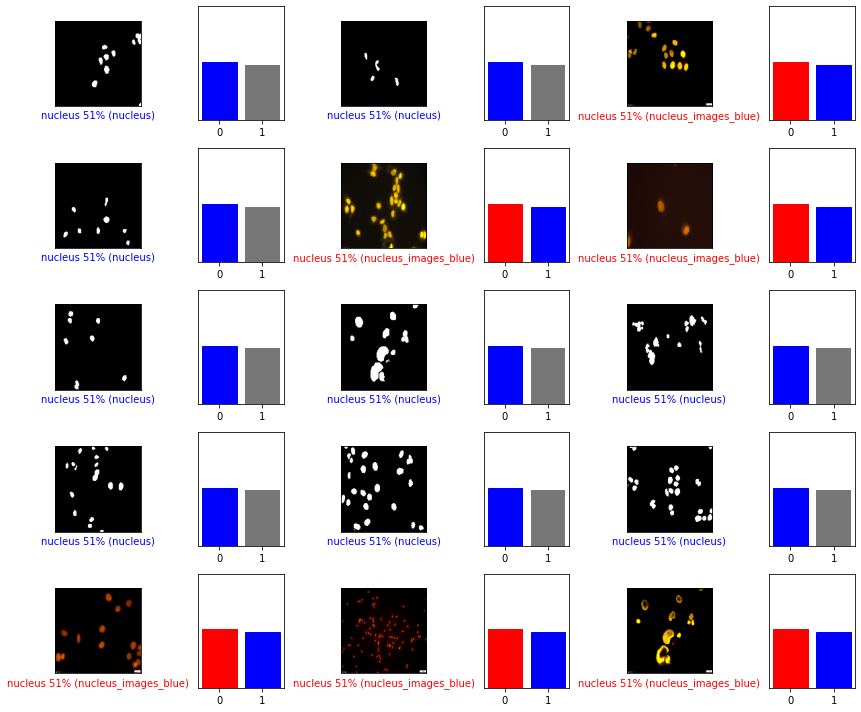

In [31]:
# Verify predictions
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], testY, testX)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], testY)
plt.tight_layout()
plt.show()
